# Speech Convergence

Convergence is computed on word pairs. For a word pair to be a convergent one, the acoustic properties of the words for the two speakers must become more similar to each other.

![title](docs/img/Convergence_criteria.png)


## Run the notebook

In [119]:
# init
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

subject_name = ['stella','juliet','shai','ayoub','lucas','simone','henry', 'julien',
                'marion','elvira']
partner_name = ['juliet','stella','ayoub','shai','simone','lucas','julien', 'henry', 
                'elvira','marion']
subject_group_no = [1,1,2,2,3,3,4,4,5,5]

session_name = ['pre','duet1', 'duet2', 'duet3' ,'duet4','duet5','duet6','post']


In [120]:
# load data
duet_scores = pd.read_pickle('data/duet_scores.pkl')
duet_scores  = duet_scores.sort_values(by=['subject','session', 'wordNo'])
duet_scores.head()

,subject,session,wordNo,GMM_stella,GMM_juliet,GMM_shai,GMM_ayoub,GMM_lucas,GMM_simone,GMM_henry,GMM_julien,GMM_marion,GMM_elvira,wordIDX
0,ayoub,duet1,1,-0.480712,-1.815762,-1.274695,0.607142,-1.170618,0.199055,-1.024775,0.316127,-0.936675,0.059304,duet1_1
0,ayoub,duet1,2,-0.682439,-0.463548,-0.883312,0.992523,-0.911162,-0.282451,-0.735117,-0.426528,-0.692185,-0.647229,duet1_2
0,ayoub,duet1,3,0.252974,-1.128935,-1.544956,0.667604,-0.862632,-0.434648,-1.276315,-0.124275,-0.978689,0.478533,duet1_3
0,ayoub,duet1,4,-0.283780,-1.516061,-1.193692,1.506307,-0.982213,0.077695,-1.697411,0.357814,-1.646500,0.064793,duet1_4
0,ayoub,duet1,5,0.123190,-1.488713,-1.944007,1.275417,-1.430166,-0.326952,-1.817676,0.375320,-1.583974,0.147306,duet1_5


### Convergence criteria
Compute the distribution of LLR score difference between own model and partner model. We call it baseline_threshold and we get it for each speaker. We get the 5 , 50 and 95 percentile of this distribution.

For test speech we compute the LLR score difference (y) between own model and partner model. Now if:

    baseline_threshold(5)< y < baseline_threshold(95) = No change
    y <= baseline_threshold(5) = Convergence
    y >= baseline_threshold(95) = Divergence
    

In [121]:
# compute baseline threshold for each subjects with [5 50 95] percentile
session = session_name[7]
print('baseline threshold is computed on the session = '+session)

baseline_threshold = []
for i in range(0,len(subject_name)):
    s=subject_name[i]
    p=partner_name[i]
    a=duet_scores[(duet_scores['session']==session)&
                  (duet_scores['subject']==s)]['GMM_'+s].get_values()

    b=duet_scores[(duet_scores['session']==session)&
                  (duet_scores['subject']==s)]['GMM_'+p].get_values()
    
    baseline_threshold.append((np.percentile(a-b,5),np.percentile(a-b,50),np.percentile(a-b,95)))
baseline_threshold = np.stack(baseline_threshold)    
baseline_threshold    


baseline threshold is computed on the session = post


array([[ 0.33365847,  1.47353121,  2.68193454],
       [ 0.04267303,  1.07165722,  1.7855889 ],
       [ 0.7557219 ,  1.53970878,  2.37345243],
       [ 0.99759301,  2.10277477,  3.15677467],
       [ 0.2416694 ,  0.80858375,  1.2396514 ],
       [-0.165991  ,  0.73900217,  1.37287568],
       [ 0.76510855,  1.41287124,  2.2386854 ],
       [ 0.84049534,  1.69905127,  2.77409626],
       [ 0.60807674,  1.50376999,  2.35127932],
       [ 0.33741813,  1.53726791,  2.54546658]])

In [122]:
# convergence computation
def get_convergence(A,baseline_threshold):

    strategies = []
    for i in range(0,A.shape[0]):        
        s = A.iloc[i]['subject']
        s_idx = subject_name.index(s)
        p = partner_name[s_idx]
        
        a = A.iloc[i]['GMM_'+s] - A.iloc[i]['GMM_'+p]
        
        
        NoChange = 0
        Convergence = 0
        Divergence = 0
        score_diff=0
        if(baseline_threshold[s_idx,0]<a<baseline_threshold[s_idx,2]):
            NoChange = 1
        elif(baseline_threshold[s_idx,0]>=a):
            Convergence = 1
        elif(baseline_threshold[s_idx,2]<=a):
            Divergence = 1
            
        aa = np.where(np.asarray(subject_name)==A.iloc[i]['subject'])[0][0]
        
        
        a = pd.DataFrame({'group':subject_group_no[aa]-1,'wordNo':A.iloc[i]['wordNo'],
                          'subject':A.iloc[i]['subject'],
                          'session':session_name.index(A.iloc[i]['session']),
                          'NoChange':[NoChange],'Convergence':Convergence,
                          'Divergence':Divergence,
                          'mean_score_ratio':a / baseline_threshold[s_idx,1]})    
        strategies.append(a)     

    strategies = pd.concat((strategies),axis=0)
    return strategies


strategies = get_convergence(duet_scores,baseline_threshold)
strategies = strategies.melt(['group','wordNo','subject','session','mean_score_ratio'], 
                             var_name='type', value_name='data')
strategies.head()

,group,wordNo,subject,session,mean_score_ratio,type,data
0,1,1,ayoub,1,0.894930,NoChange,1
1,1,2,ayoub,1,0.892076,NoChange,1
2,1,3,ayoub,1,1.052209,NoChange,1
3,1,4,ayoub,1,1.284017,NoChange,1
4,1,5,ayoub,1,1.531036,NoChange,0


### Visualize the results

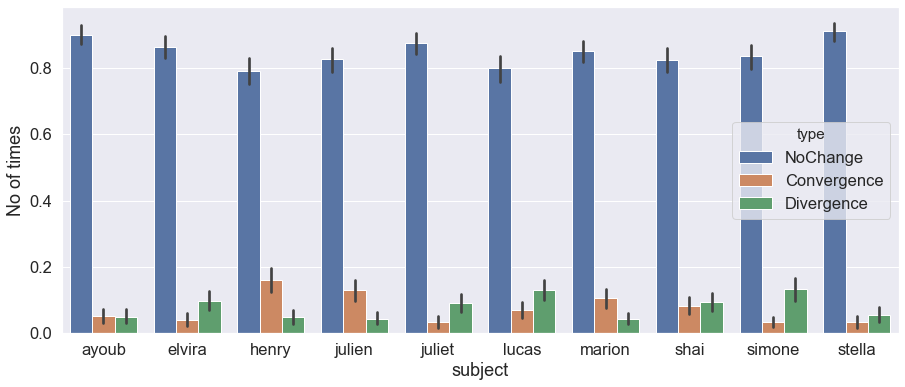

In [123]:
# Plot
sns.set(font_scale=1.5)


f, AX = plt.subplots(figsize=(15,6))

ax = sns.barplot(x="subject", y="data", hue='type',data=strategies)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

#change_width(ax, .65)
_=plt.ylabel('No of times')
#_=plt.xlim([-1,10])